In [1]:
import os
import time

import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

2022-02-28 18:11:22.933424: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-28 18:11:22.933457: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
epochs = 20
number_of_examples = 8
batch_size = 16
latent_dim = 100
image_size = (64, 64) # h x w

seed = tf.random.normal([number_of_examples, latent_dim])

data_dir = r'../input/animal-faces/afhq/train/'

dataset = keras.preprocessing.image_dataset_from_directory(
    data_dir, label_mode=None, image_size=image_size, batch_size=batch_size
)

2022-02-28 18:11:25.911828: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-28 18:11:25.911880: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-28 18:11:25.911918: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Inspiron-5558): /proc/driver/nvidia/version does not exist
2022-02-28 18:11:25.912359: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 0 files belonging to 1 classes.


ValueError: No images found.

In [5]:
dataset = dataset.map(lambda x: (x - 127.5) / 127.5) # Normalizing to -1,1

In [3]:
def make_generator_model(latent_dim):
    visible = keras.layers.Input(shape=[latent_dim])
    hidden = keras.layers.Reshape((1, 1, 100))(visible)

    hidden = keras.layers.Conv2DTranspose(filters=512, kernel_size=4, strides=(1, 1),
                                          padding='valid', activation="relu")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)
    out4x4 = hidden
    out4x4 = keras.layers.Conv2D(filters=3, kernel_size=4, strides=(1, 1), padding='same')(out4x4)
    out4x4 = keras.layers.Activation("tanh")(out4x4)


    hidden = keras.layers.Conv2DTranspose(filters=256, kernel_size=4, strides=(2, 2),
                                          padding='same', activation="relu")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)
    out8x8 = hidden
    out8x8 = keras.layers.Conv2D(filters=3, kernel_size=4, strides=(1, 1), padding='same')(out8x8)
    out8x8 = keras.layers.Activation("tanh")(out8x8)


    hidden = keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=(2, 2),
                                          padding='same', activation="relu")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)
    out16x16 = hidden
    out16x16 = keras.layers.Conv2D(filters=3, kernel_size=4, strides=(1, 1), padding='same')(out16x16)
    out16x16 = keras.layers.Activation("tanh")(out16x16)


    hidden = keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2),
                                          padding='same', activation="relu")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)
    out32x32 = hidden
    out32x32 = keras.layers.Conv2D(filters=3, kernel_size=4, strides=(1, 1), padding='same')(out32x32)
    out32x32 = keras.layers.Activation("tanh")(out32x32)


    hidden = keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2),
                                          padding='same', activation="relu")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)
    hidden = keras.layers.Conv2D(filters=3, kernel_size=4, strides=(1, 1), padding='same')(hidden)
    out64x64 = keras.layers.Activation("tanh")(hidden)
    model = keras.models.Model(inputs=visible, outputs=[out64x64, out32x32, out16x16, out8x8, out4x4])

    return model

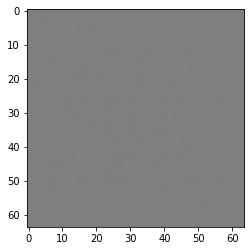

In [4]:
generator = make_generator_model(latent_dim)

noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0][0].numpy()*127.5+127.5).astype("uint32"))

In [5]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 1, 100)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 4, 4, 512)    819712      reshape[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4, 4, 512)    2048        conv2d_transpose[0][0]           
______________________________________________________________________________________________

In [10]:
def make_discriminator_model():
    input1 = keras.layers.Input(shape=(64, 64, 3))
    hidden = keras.layers.Conv2D(filters=64, kernel_size=4, strides=2, padding="same",
                                 activation="relu", kernel_initializer="he_normal")(input1)
    hidden = keras.layers.BatchNormalization()(hidden)

    input2 = keras.layers.Input(shape=(32, 32, 3))
    hidden = keras.layers.Concatenate()([hidden, input2])
    hidden = keras.layers.Conv2D(filters=128, kernel_size=4, strides=2, padding="same",
                                 activation="relu", kernel_initializer="he_normal")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)

    input3 = keras.layers.Input(shape=(16, 16, 3))
    hidden = keras.layers.Concatenate()([hidden, input3])
    hidden = keras.layers.Conv2D(filters=256, kernel_size=4, strides=2, padding="same",
                                 activation="relu", kernel_initializer="he_normal")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)

    input4 = keras.layers.Input(shape=(8, 8, 3))
    hidden = keras.layers.Concatenate()([hidden, input4])
    hidden = keras.layers.Conv2D(filters=512, kernel_size=4, strides=2, padding="same",
                                 activation="relu", kernel_initializer="he_normal")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)

    input5 = keras.layers.Input(shape=(4, 4, 3))
    hidden = keras.layers.Concatenate()([hidden, input5])

    hidden = keras.layers.Conv2D(filters=100, kernel_size=4, strides=1, padding="valid", activation="relu")(hidden)
    hidden = keras.layers.Flatten()(hidden)
    out = keras.layers.Dense(1)(hidden)
    #out = keras.layers.Activation("sigmoid")(hidden)
    

    model = keras.models.Model(inputs=[input1, input2, input3, input4, input5], outputs=[out])
    return model

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image, training=False)
print(decision)

tf.Tensor([[0.49975345]], shape=(1, 1), dtype=float32)


In [12]:
discriminator.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 32, 64)   3136        input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 32, 32, 64)   256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
____________________________________________________________________________________________

In [36]:
if not os.path.isdir("epochs"):
    os.mkdir("epochs")
def plot_examples(images_at_scales, epoch):
    n_examples = images_at_scales[0].shape[0]
    fig, axes = plt.subplots(figsize=(5, n_examples), nrows=n_examples, ncols=5, dpi=100)
    for i in range(n_examples):
        for j in range(5):
            generated_images = images_at_scales[4-j]
            gen_1 = generated_images[i].numpy()*127.5+127.5
            axes[i, j].axis('off')
            axes[i, j].imshow((gen_1).astype("uint32"), interpolation='none')
    plt.savefig('epochs/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [37]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

# The generator is performing well, if the discriminator classifies fakes as real(1)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [38]:
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

In [39]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [40]:
@tf.function
def train_step(images):
    noise = random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss,
        generator.trainable_variables
    )

    gradients_of_discriminator = disc_tape.gradient(
        disc_loss,
        discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator,
            generator.trainable_variables)
        )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator,
            discriminator.trainable_variables)
        )

    return (gen_loss, disc_loss)

In [41]:
def scale_input_images(image_batch):
    result = []
    result.append(image_batch)
    result.append(tf.image.resize(image_batch, [32, 32]))
    result.append(tf.image.resize(image_batch, [16, 16]))
    result.append(tf.image.resize(image_batch, [8, 8]))
    result.append(tf.image.resize(image_batch, [4, 4]))
    
    return result

In [42]:
def train(dataset, epochs):
    generator_losses = np.empty((0, 0), dtype=float)
    discriminator_losses = np.empty((0, 0), dtype=float)
    for epoch in range(epochs):
        start = time.time()
        
        batch_generator_losses = np.empty((0, 0), dtype=float)
        batch_discriminator_losses = np.empty((0, 0), dtype=float)
        for (batch, image_batch) in enumerate(dataset):
            scaled_batch = scale_input_images(image_batch)
            gen_loss, disc_loss = train_step(scaled_batch)
            
            if batch % 100 == 0:
                average_batch_loss =\
                   gen_loss.numpy()/int(image_batch.shape[1])
                print(f"""Epoch {epoch+1}
                        Batch {batch} Loss {average_batch_loss:.4f}""")

            batch_generator_losses = np.append(batch_generator_losses, gen_loss)
            batch_discriminator_losses = np.append(batch_discriminator_losses, disc_loss)
            
        if generator_losses.shape == (0, 0):
            generator_losses = batch_generator_losses
            discriminator_losses = batch_discriminator_losses
        else:
            generator_losses = np.vstack(
                [generator_losses, batch_generator_losses]
            )
            discriminator_losses = np.vstack(
                [discriminator_losses, batch_discriminator_losses]
            )
            
        # Saving the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Producing images for the GIF
        #display.clear_output(wait=True)
        example_images = generator(seed, training=False)
        plot_examples(example_images, epoch)
        

    # Generating after the final epoch
    example_images = generator(seed, training=False)
    plot_examples(example_images, epoch)
    
    return (generator_losses, discriminator_losses)

In [51]:
# Training the model
(generator_losses, discriminator_losses) = train(dataset, 50)

In [52]:
gen = generator_losses[:epochs].mean(axis=1) / batch_size
disc = discriminator_losses[:epochs].mean(axis=1) / batch_size

fig_1 = plt.figure(figsize=(8, 4), dpi=100)
ax = fig_1.add_axes([0, 0, 1, 1])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('DCGAN hibaértékei az első 50 epoch alatt')
ax.plot(np.linspace(1, epochs, epochs), gen, label='Generator')
ax.plot(np.linspace(1, epochs, epochs), disc, label='Discriminator')
ax.legend(loc=0)

ax.grid(True, color='0.6', dashes=(5, 2, 1, 2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

x_ticks = np.arange(0, epochs+1, 5)
x_ticks[0] = 1
ax.set_xticks(x_ticks)
plt.show()

In [61]:
noises = tf.random.normal([16, latent_dim])
example_images = generator(noises, training=False)

plt.imshow((example_images[0][0].numpy()*127.5+127.5).astype("uint32"), interpolation='none')
plot_examples(example_images, 0)